In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

project_name = 'DataSet/Xenium_immune'
cmap='viridis'


In [2]:
position = pd.read_csv(f'{project_name}/reordered_position_with_center.csv')
row_all = position['imagerow'].tolist()
col_all = position['imagecol'].tolist()

In [4]:
merge_position = position[position['is_center']==1]
merge_position

,Unnamed: 0,row,col,imagerow,imagecol,is_center
8,8,0,0,11167,21167,1
17,17,3,0,12167,21167,1
26,26,6,0,13167,21167,1
35,35,9,0,14167,21167,1
44,44,12,0,15167,21167,1
...,...,...,...,...,...,...
1484,1484,24,36,19167,33167,1
1493,1493,27,36,20167,33167,1
1502,1502,30,36,21167,33167,1
1511,1511,33,36,22167,33167,1


In [38]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr
from scipy.stats import wasserstein_distance as WD
import seaborn as sns
import matplotlib.pyplot as plt

# data = pd.read_csv(f'{project_name}/reordered_count.csv').fillna(0)
# data_spatial_1 = pd.read_csv(f'{project_name}/bayesspace_count_2.csv', index_col=0)

log = False
# log = True
method_names = ['reordered_count_all', 'data_ours_d32', 'data_ours_d16', 'data_ours_d8', 'data_ours_d4', 'data_ours_d2', 'data_ours_d1']
data_dic = {}
for key in method_names:
    if not log:
        data_dic[key] = pd.read_csv(f'{project_name}/{key}.csv', index_col=0).fillna(0)
    else:
        data_dic[key] = pd.read_csv(f'{project_name}/{key}_log_counts.csv').fillna(0)

data_control = pd.read_csv(f'{project_name}/count_merge.csv').fillna(0)
position = pd.read_csv(f'{project_name}/reordered_position_with_center.csv')

row = np.array(position['imagerow'].tolist())
col = np.array(position['imagecol'].tolist())

r_position = pd.read_csv(f'{project_name }/colData_merge.csv')

row_r = r_position['row'].tolist()
col_r = r_position['col'].tolist()


In [39]:
for key in method_names:
    df = data_dic[key]
    df_log1p = np.log1p(df)
    data_dic[f'{key}_lognorm'] = df_log1p

In [6]:
import matplotlib.pyplot as plt
import matplotlib
cmp = 'viridis'

In [7]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Supp Fig 4g

T cells
B cells
Macrophage


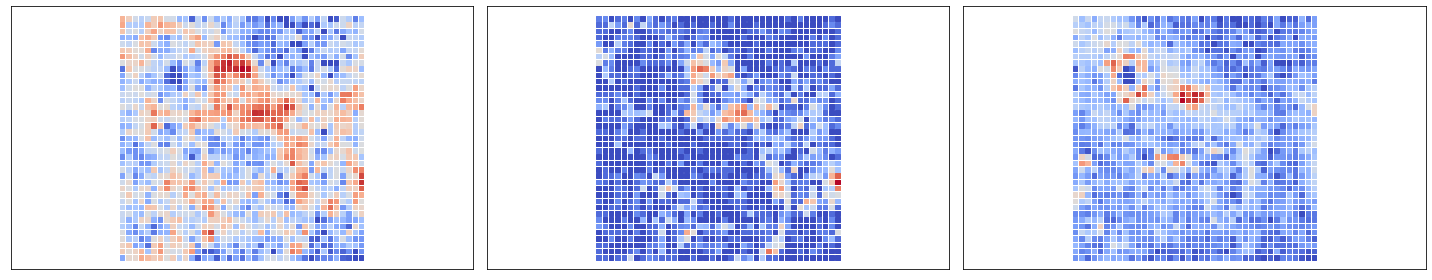

In [81]:
cell_type = {
    'T cells': ['CXCR4', 'CD8A', 'TRAC', 'CD4'],
    'B cells': ['MS4A1', 'BANK1'],
    'Macrophage': ['APOC1', 'MMP12', 'C15orf48', 'ITGAX', 'CD68']
}
order = ['data_ours_d1', 'data_ours_d4', 'data_ours_d8', 'data_ours_d32']
cmp = 'coolwarm'
i = 0
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
for cell in cell_type.keys():
    print(cell)
    
    exp_gt = 0
    spot_x = -position['col']
    spot_y = position['row']
    for g in cell_type[cell]:
        exp_gt += data_dic['reordered_count_all_lognorm'][g]


    img = axes[i].scatter(spot_x, spot_y, s=20, marker='s', c=exp_gt, cmap=cmp)
    axes[i].axis("equal")
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    i += 1
plt.savefig(f'{project_name }/{cell}.pdf')
plt.tight_layout()
plt.show()

# Supp Fig 4h

CXCR4


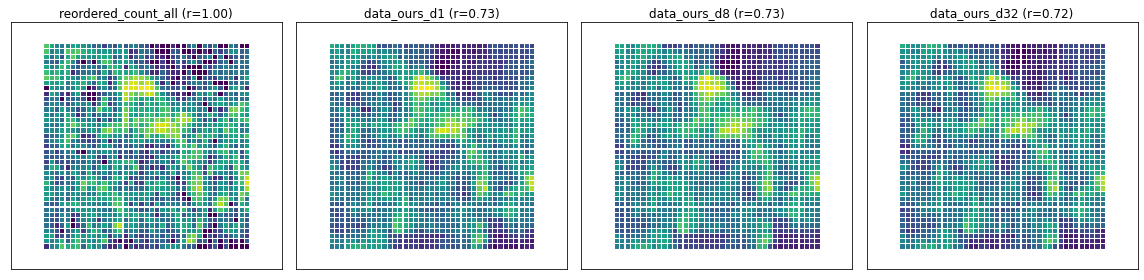

CD8A


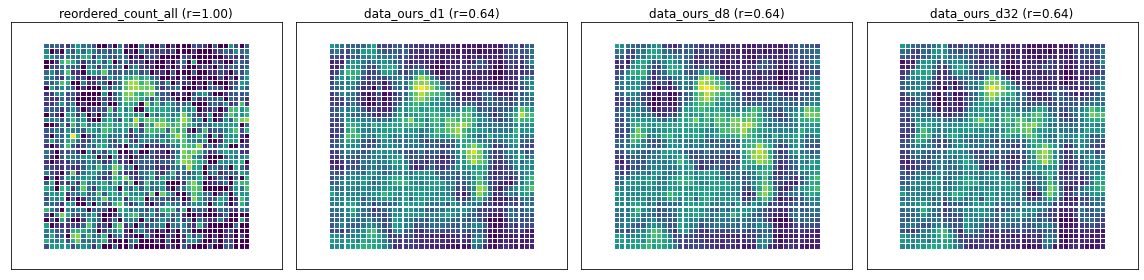

TRAC


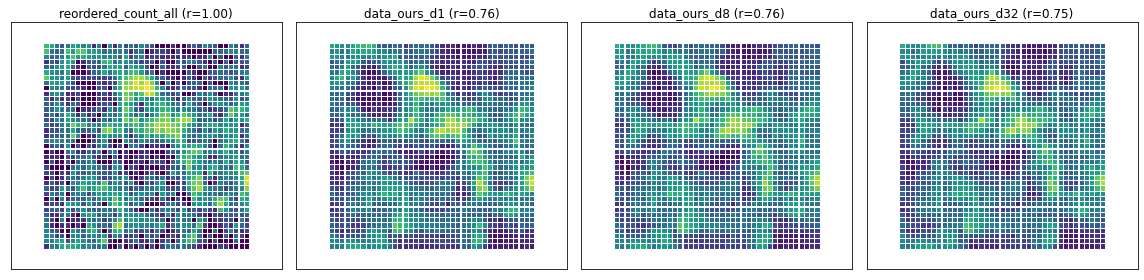

CD4


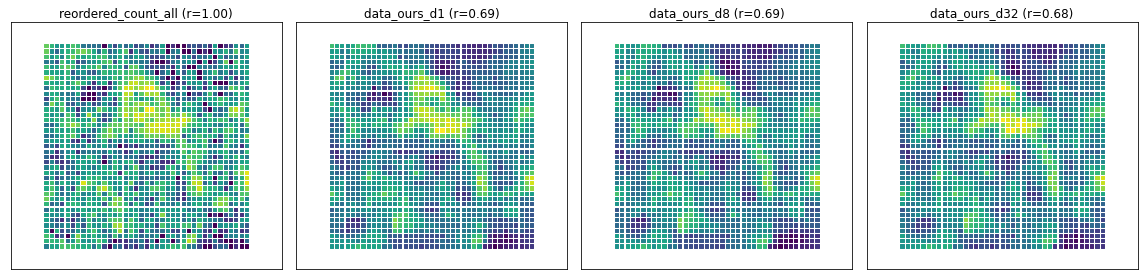

MS4A1


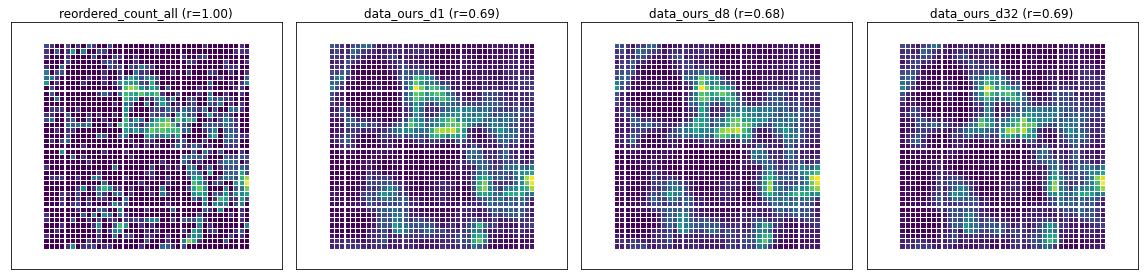

BANK1


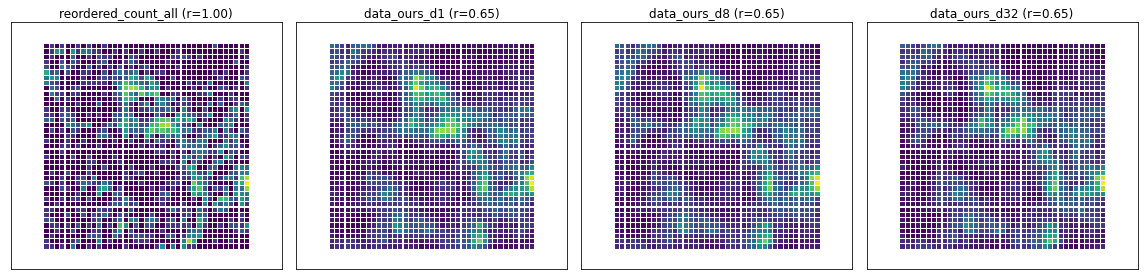

APOC1


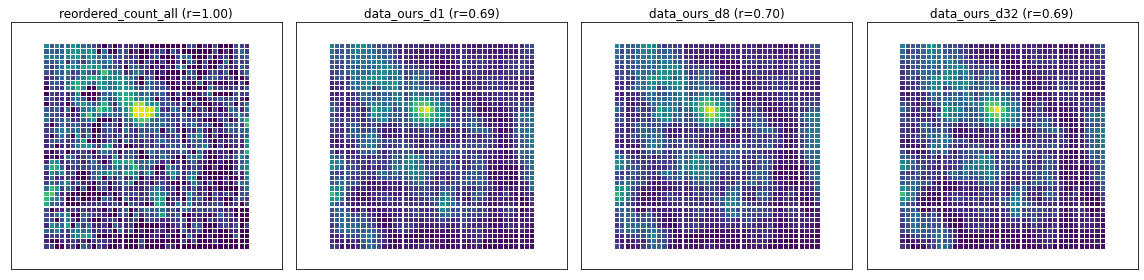

MMP12


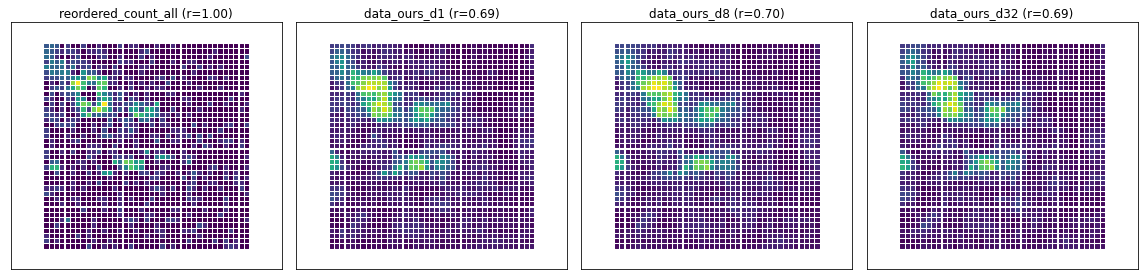

C15orf48


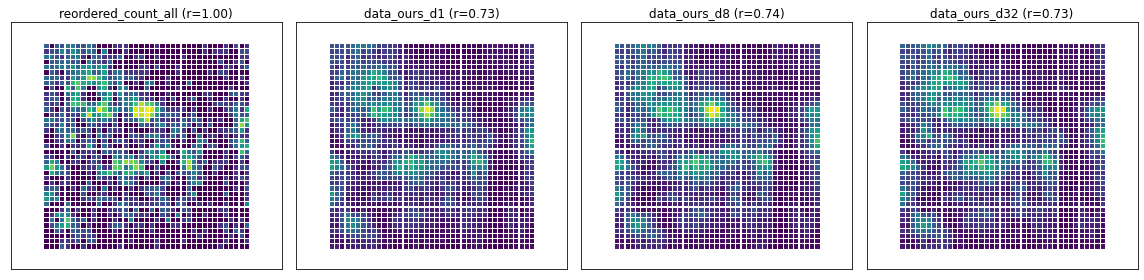

ITGAX


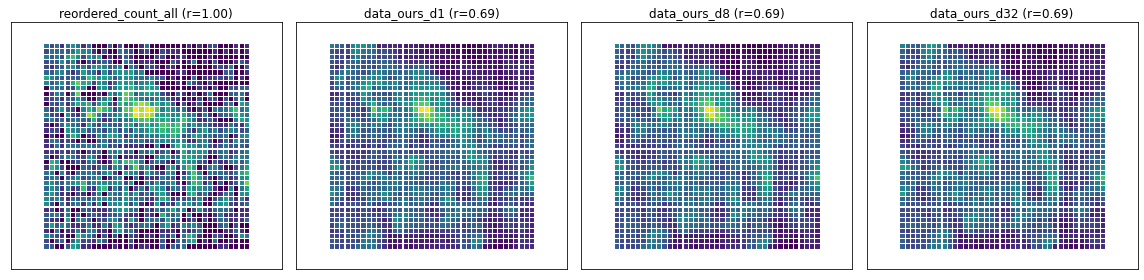

CD68


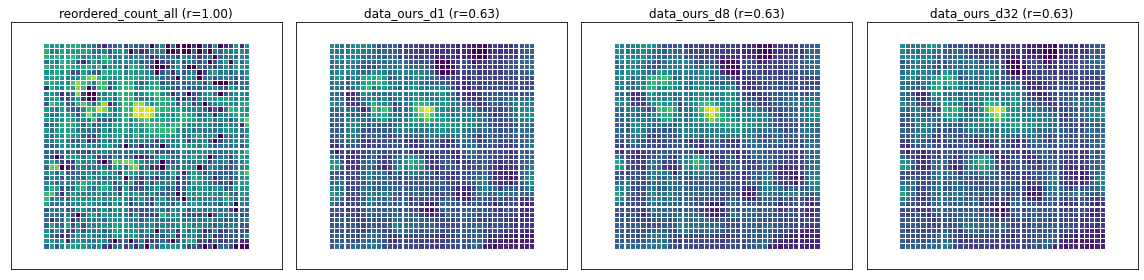

In [85]:
g_list = data_dic['data_ours_d1'].keys().tolist()
order = ['data_ours_d1', 'data_ours_d8', 'data_ours_d32']
cmp = 'viridis'
for g in g_list:
    print(g)
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    for i, key in enumerate(['reordered_count_all']+order, start=0):
        c = data_dic[f'{key}_lognorm'][g]
        exp_gt = data_dic['reordered_count_all_lognorm'][g]
        spot_x = -position['col']
        spot_y = position['row']

        img = axes[i].scatter(spot_x, spot_y, s=10, marker='s', c=c, cmap=cmp)
        pearson_, _ = pearsonr(exp_gt, c)
        axes[i].set_title(f'{key} (r={pearson_:.2f})')
        axes[i].axis("equal")
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    plt.savefig(f'{project_name }/{g}_lognorm.pdf')
    plt.tight_layout()
    plt.show()

# Supp Fig 4i

In [87]:
def norm(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range
 
 
def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma

pearson_dic = {}
mse_dic = {}
norm_mse_dic = {}

for key in method_names[1:]:
    pearson_dic[key] = []
    mse_dic[key] = []
    norm_mse_dic[key] = []

# ['reordered_count_all', 'data_ours', 'data_ours_marker_noimage', 'data_ours_noimage_nomarker', 'data_ours_nomarker']
top_gene = data_dic['data_ours_d1'].keys().tolist()
for i in range(len(top_gene)):
    gene = top_gene[i]
    exp_gt = data_dic['reordered_count_all'][gene]
    for key in order:
        exp_ = data_dic[key][gene]
        # pearson
        pearson_, _ = pearsonr(exp_gt, exp_)
        # mse
        mse_ = mean_squared_error(exp_gt, exp_)
        norm_mse_ = mean_squared_error(norm(exp_gt), norm(exp_))
        pearson_dic[key].append(pearson_)
        mse_dic[key].append(mse_)
        norm_mse_dic[key].append(norm_mse_)

In [88]:
def norm(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range
 
 
def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma

pearson_log_dic = {}
mse_log_dic = {}
norm_mse_log_dic = {}

for key in method_names[1:]:
    pearson_log_dic[key] = []
    mse_log_dic[key] = []
    norm_mse_log_dic[key] = []

# ['reordered_count_all', 'data_ours', 'data_ours_marker_noimage', 'data_ours_noimage_nomarker', 'data_ours_nomarker']
top_gene = data_dic['data_ours_d1_lognorm'].keys().tolist()[1:]
for i in range(len(top_gene)):
    gene = top_gene[i]
    exp_gt = data_dic['reordered_count_all_lognorm'][gene]
    for key in order:
        exp_ = data_dic[f"{key}_lognorm"][gene]
        # pearson
        pearson_, _ = pearsonr(exp_gt, exp_)
        # mse
        mse_ = mean_squared_error(exp_gt, exp_)
        norm_mse_ = mean_squared_error(norm(exp_gt), norm(exp_))
        pearson_log_dic[key].append(pearson_)
        mse_log_dic[key].append(mse_)
        norm_mse_log_dic[key].append(norm_mse_)

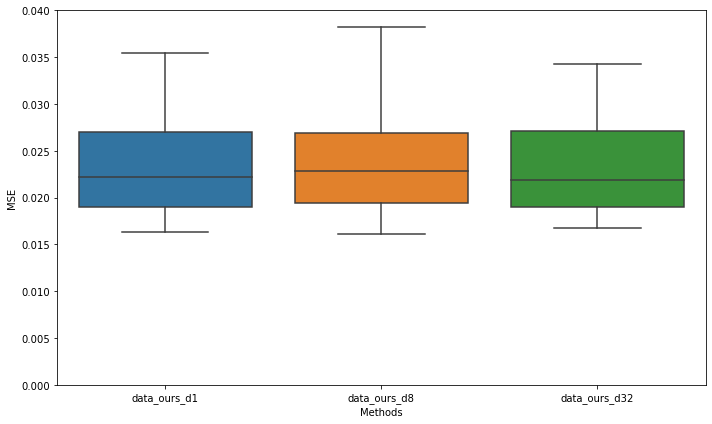

In [90]:
order_log = [f'{key}_lognorm' for key in order]
norm_mse_log_df = pd.DataFrame([(method, mse) for method, mses in norm_mse_log_dic.items() for mse in mses], 
                       columns=['Methods', 'MSE'])

plt.figure(figsize=(10, 6))
sns.boxplot(x='Methods', y='MSE', data=norm_mse_log_df, order=order)
plt.ylim(0, 0.04)
plt.tight_layout()
plt.savefig(f'{project_name}/marker_mse_log.pdf', pad_inches=0)
plt.show()

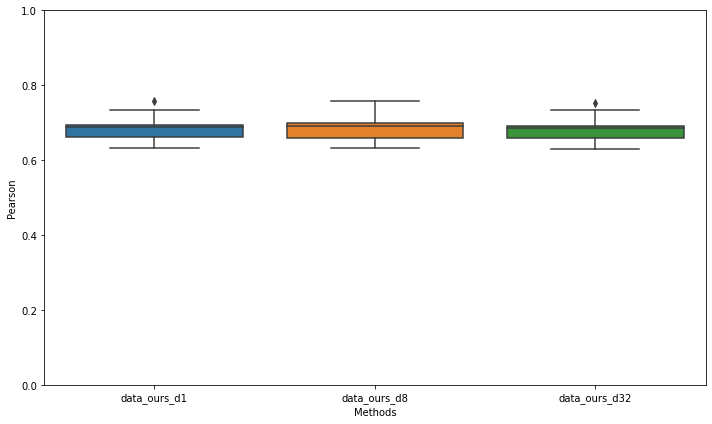

In [92]:
pearson_log_df = pd.DataFrame([(method, pearson) for method, pearsons in pearson_log_dic.items() for pearson in pearsons], 
                       columns=['Methods', 'Pearson'])

plt.figure(figsize=(10, 6))
sns.boxplot(x='Methods', y='Pearson', data=pearson_log_df, order=order)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig(f'{project_name}/marker_person_log.pdf', pad_inches=0)
plt.show()